# Importing the all the necessary Packages

In [2]:

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, accuracy_score
import sys

import cv2
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset


print(os.listdir())





['.config', 'sample_data']


# Extracting the Data

In [4]:
import zipfile
zip_path = "archive.zip"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("archive")

# Check the extraction
print(os.listdir())

# Listing out the extracted files
print("check")
print(os.listdir("./archive/archive"))


['.config', 'archive', 'archive.zip', 'sample_data']
check
['yes', 'no']


#Plotting graph for the data we Have

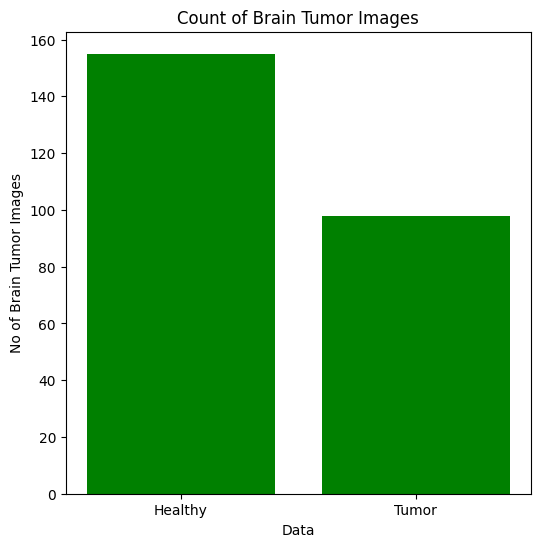

In [5]:

directory = "./archive/archive"
MapArray = np.array(["Healthy","Tumor"])
data = {}

for index, folder in enumerate(os.listdir(directory)):
    numberOfFiles = len(os.listdir(os.path.join(directory,folder)))
    data[MapArray[index]] = numberOfFiles


typex = data.keys()
values = data.values()



typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(6,6))

plt.bar(typex, values, color="green")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()


# Changing the File Names and Extensions to make it more comfortable for data manipulation

In [6]:
directory = "./archive/archive"
foldersArray = ["nt_", "h_"]

for index, folder in enumerate(os.listdir(directory)):
    folderPath = os.path.join(directory, folder)
    for index2, file in enumerate(os.listdir(folderPath)):
        fileNo = index2 + 1
        newName = foldersArray[index] + str(fileNo) + ".jpg"
        oldPath = os.path.join(folderPath, file)
        newPath = os.path.join(folderPath, newName)
        os.rename(oldPath, newPath)


# Reading the Images


In [7]:
healthy = []
tumor = []

#defining function for reading IMages from different folders for different cases
def readImages(array, path):
    for imageName in glob.iglob(f"./{path}/*.jpg"):
        img = cv2.imread(imageName)
        img = cv2.resize(img, (128, 128))
        b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])
        array.append(img)

#Calling functions for folders for different types
readImages(healthy, "./archive/archive/no")
readImages(tumor, "./archive/archive/yes")

#Converting the Existing Arrays into Numpy arrays
healthy = np.array(healthy)
tumor = np.array(tumor)
#Concatenating all the arrays with diiferent or not types of tumor into one
allTumorImages = np.concatenate((healthy, tumor), axis=0)

In [8]:
print("Healthy : ",healthy.shape)

Healthy :  (98, 128, 128, 3)


In [9]:
print("Tumor : ",tumor.shape)

Tumor :  (155, 128, 128, 3)


# Visualizing the Read Images

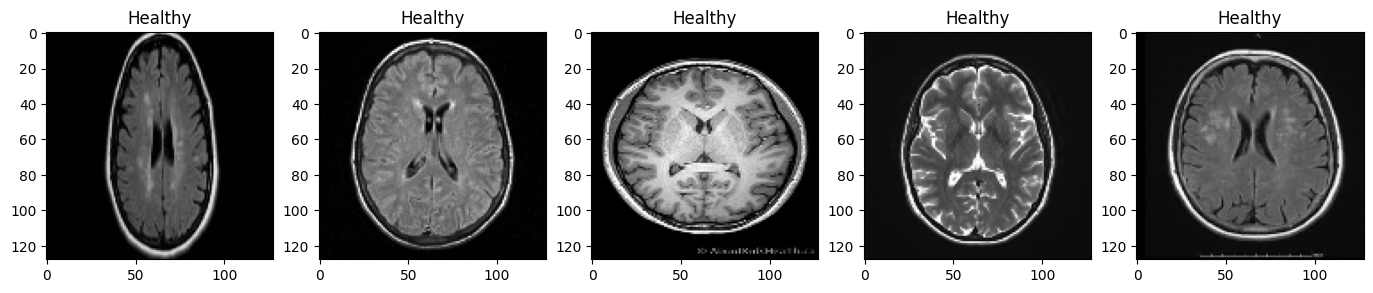

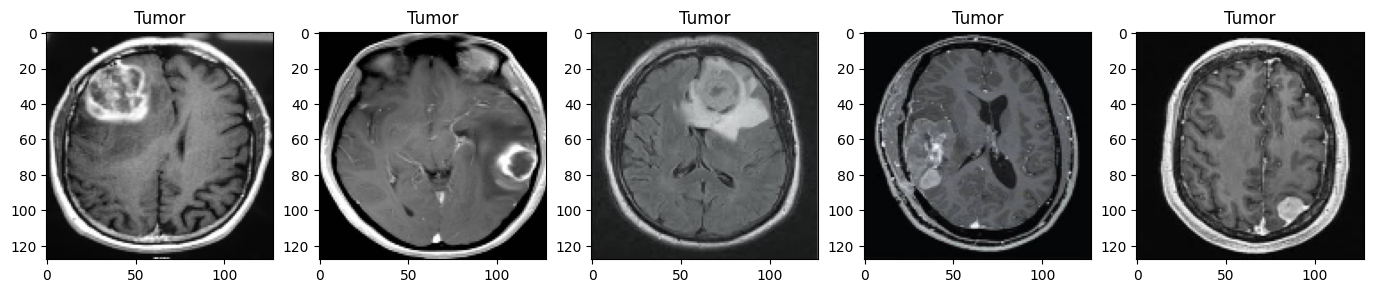

In [10]:
#defining function for plotting the images
def plotRandomImages(array, title,num=5):
    type_imgs = array[np.random.choice(array.shape[0], num)]

    plt.figure(figsize=(17,10))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title(f'{title}')
        plt.imshow(type_imgs[i])
        #print(type_imgs[i].shape)


#Calling functions for folders for different types
plotRandomImages(healthy,"Healthy")
plotRandomImages(tumor,"Tumor")



#Creating our own Custom Datset Class

In [11]:
class BrainTumor(Dataset):
    def __init__(self):

        healthy = []
        tumor = []

        self.readAndReshapeImages(tumor, "./archive/archive/yes")
        self.readAndReshapeImages(healthy, "./archive/archive/no")

        #our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

         #our labels
        t_Labels =  np.ones(tumor.shape[0], dtype=np.float32)
        non_t_Labels = np.zeros(healthy.shape[0], dtype=np.float32)

        #All Images
        self.images = np.concatenate((tumor, healthy), axis=0)
        #All Labels
        self.labels = np.concatenate((t_Labels,non_t_Labels), axis=0)


    def readAndReshapeImages(self,array, path):
        for imageName in glob.iglob(f"./{path}/*.jpg"):
            img = cv2.imread(imageName)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
            array.append(img)




    def __len__(self):
        return self.images.shape[0];

    def __getitem__(self, index):
        return(
            {
                "image":self.images[index],
                "label":self.labels[index]
            });

    def normalize(self):
        self.images = self.images/255.0

In [12]:
braintumor = BrainTumor()
braintumor.normalize()
check = braintumor[20]
print(check)
check["image"].shape

{'image': array([[[0.01176471, 0.01176471, 0.01176471, ..., 0.04705882,
         0.04705882, 0.04705882],
        [0.04705882, 0.04705882, 0.04705882, ..., 0.04705882,
         0.04705882, 0.04705882],
        [0.04705882, 0.04705882, 0.04705882, ..., 0.04705882,
         0.04705882, 0.04705882],
        ...,
        [0.41568628, 0.41568628, 0.42352942, ..., 0.04705882,
         0.04705882, 0.04705882],
        [0.01568628, 0.01568628, 0.01568628, ..., 0.52156866,
         0.5411765 , 0.5411765 ],
        [0.5411765 , 0.41960785, 0.41960785, ..., 0.3019608 ,
         0.3019608 , 0.43529412]],

       [[0.43529412, 0.43529412, 0.5254902 , ..., 0.04705882,
         0.04705882, 0.04705882],
        [0.01568628, 0.01568628, 0.01568628, ..., 0.46666667,
         0.41960785, 0.41960785],
        [0.41960785, 0.37254903, 0.37254903, ..., 0.31764707,
         0.31764707, 0.42745098],
        ...,
        [0.25490198, 0.25490198, 0.25490198, ..., 0.34509805,
         0.34509805, 0.29411766],
  

(3, 128, 128)

# Setting the DataLoader for the brainTumor Object we created

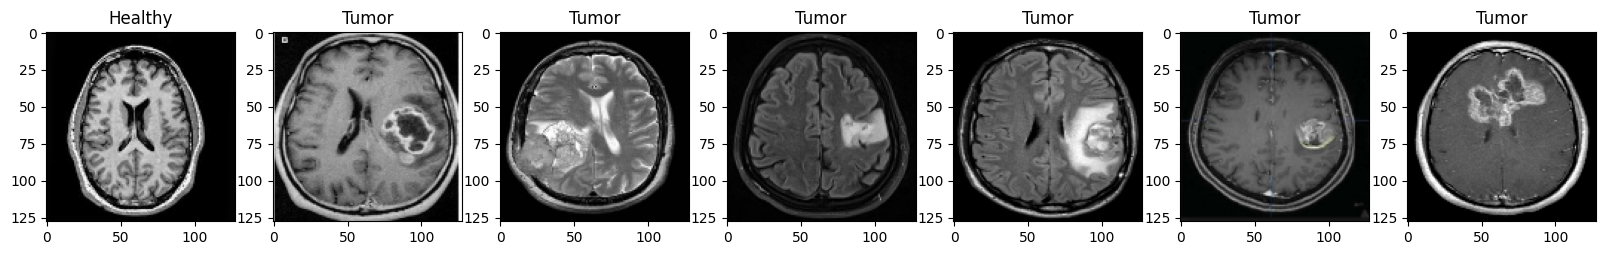

In [13]:
braintumor = BrainTumor()
braintumor.normalize()
# Shuffling the data using the DataLoader and Showing the Shuffled Data
plt.figure(figsize=(20, 12))
num = 7
labels = ["Healthy", "Tumor"]
dataLoader = DataLoader(braintumor, shuffle=True)
for i, sample in enumerate(dataLoader):
    image = sample["image"].squeeze()
    image = image.reshape(image.shape[2], image.shape[1], image.shape[0])
   # print(image.shape)
    plt.subplot(1, num, i + 1)
    plt.title(labels[int(sample["label"].item())])
    plt.imshow(image)
    if i == num - 1:
        break

plt.show()


# Creating the Model


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

#Evaluate the New Born Model Without Trainig

In [15]:
dataset = BrainTumor()
dataset.normalize()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = BrainTumorCNN().to(device)

cpu


In [16]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

#Evaluating the Dumb Model

In [17]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [18]:


outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

outputs = np.array(outputs)
y_true = np.array(y_true)

print(outputs.shape)
print(y_true.shape)

(253,)
(253,)


In [19]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

#Accuracy of Dumb Model

In [20]:
accuracy_score(y_true, threshold(outputs))


0.6126482213438735

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

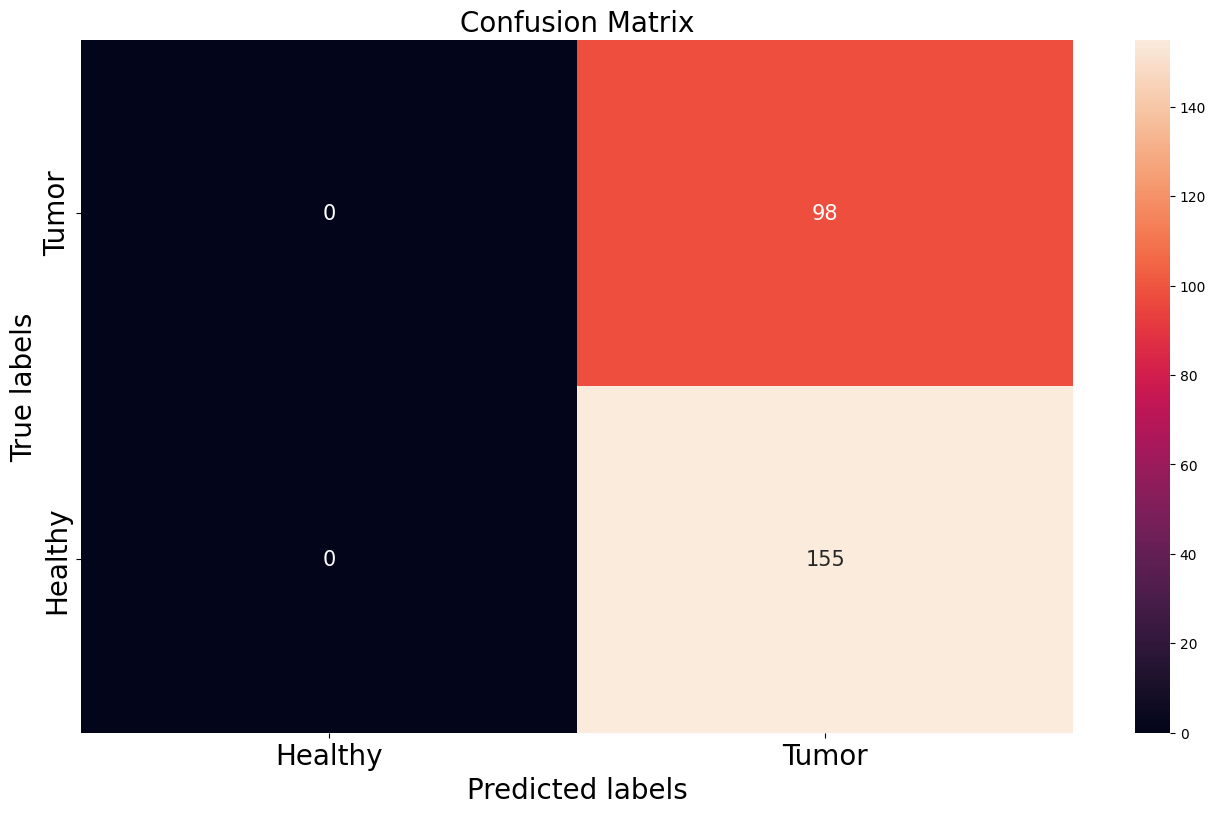

In [22]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 15})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

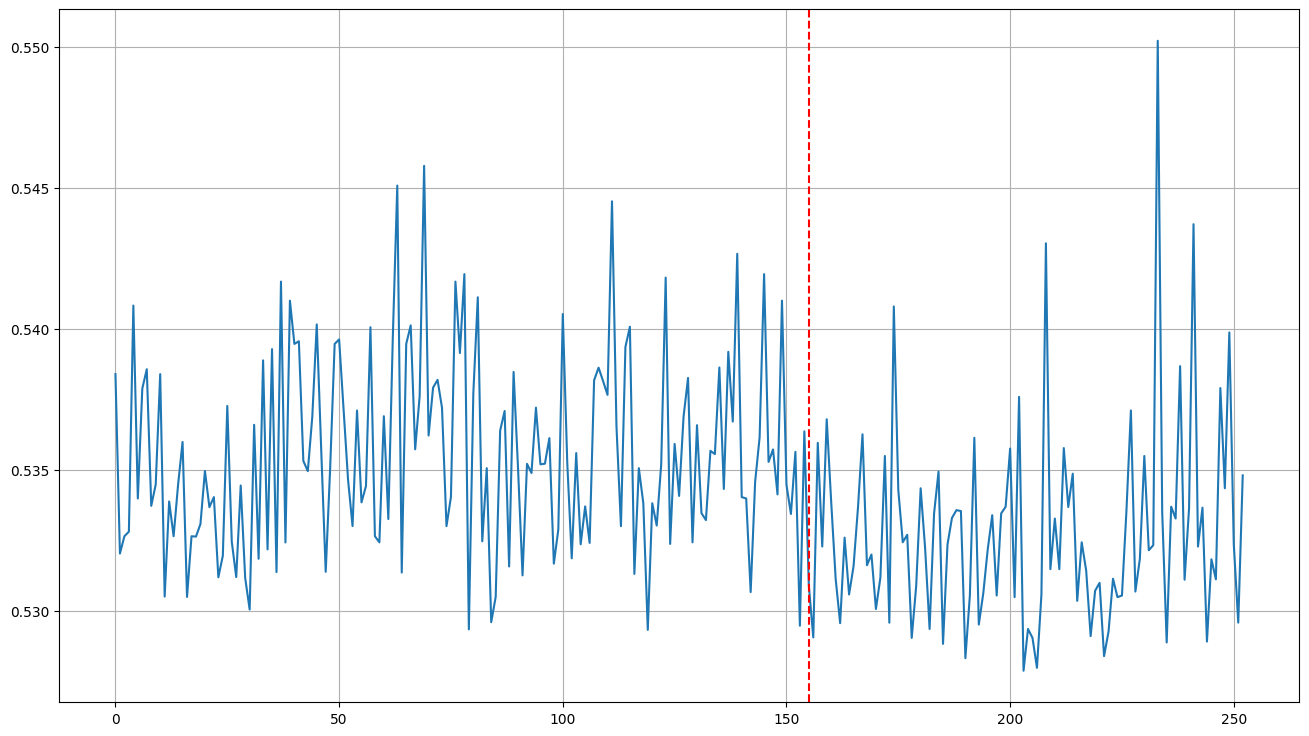

In [23]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

#Training the Model



In [24]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model.train()

BrainTumorCNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.639192
Train Epoch: 20	Loss: 0.611674
Train Epoch: 30	Loss: 0.567217
Train Epoch: 40	Loss: 0.523663
Train Epoch: 50	Loss: 0.495971
Train Epoch: 60	Loss: 0.477042
Train Epoch: 70	Loss: 0.451477
Train Epoch: 80	Loss: 0.437269
Train Epoch: 90	Loss: 0.427509
Train Epoch: 100	Loss: 0.408945
Train Epoch: 110	Loss: 0.391365
Train Epoch: 120	Loss: 0.385722
Train Epoch: 130	Loss: 0.362733
Train Epoch: 140	Loss: 0.342737
Train Epoch: 150	Loss: 0.330538
Train Epoch: 160	Loss: 0.314890
Train Epoch: 170	Loss: 0.300880
Train Epoch: 180	Loss: 0.288784
Train Epoch: 190	Loss: 0.270348
Train Epoch: 200	Loss: 0.255713
Train Epoch: 210	Loss: 0.246155
Train Epoch: 220	Loss: 0.232775
Train Epoch: 230	Loss: 0.214564
Train Epoch: 240	Loss: 0.201210
Train Epoch: 250	Loss: 0.184003
Train Epoch: 260	Loss: 0.175921
Train Epoch: 270	Loss: 0.153395
Train Epoch: 280	Loss: 0.139658
Train Epoch: 290	Loss: 0.133184
Train Epoch: 300	Loss: 0.107815
Train Epoch: 310	Loss: 0.114493
Train Epoch: 320	

#Evaluate the Trained Model

In [ ]:
model.eval()
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

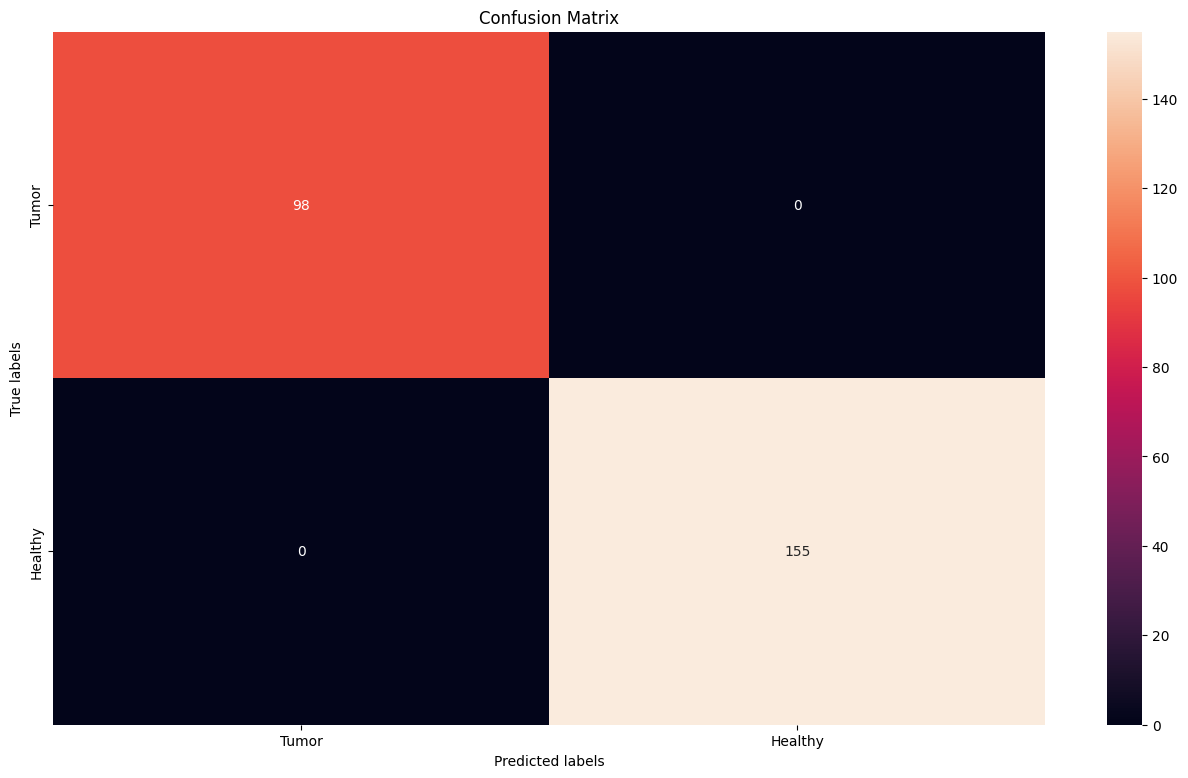

In [ ]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

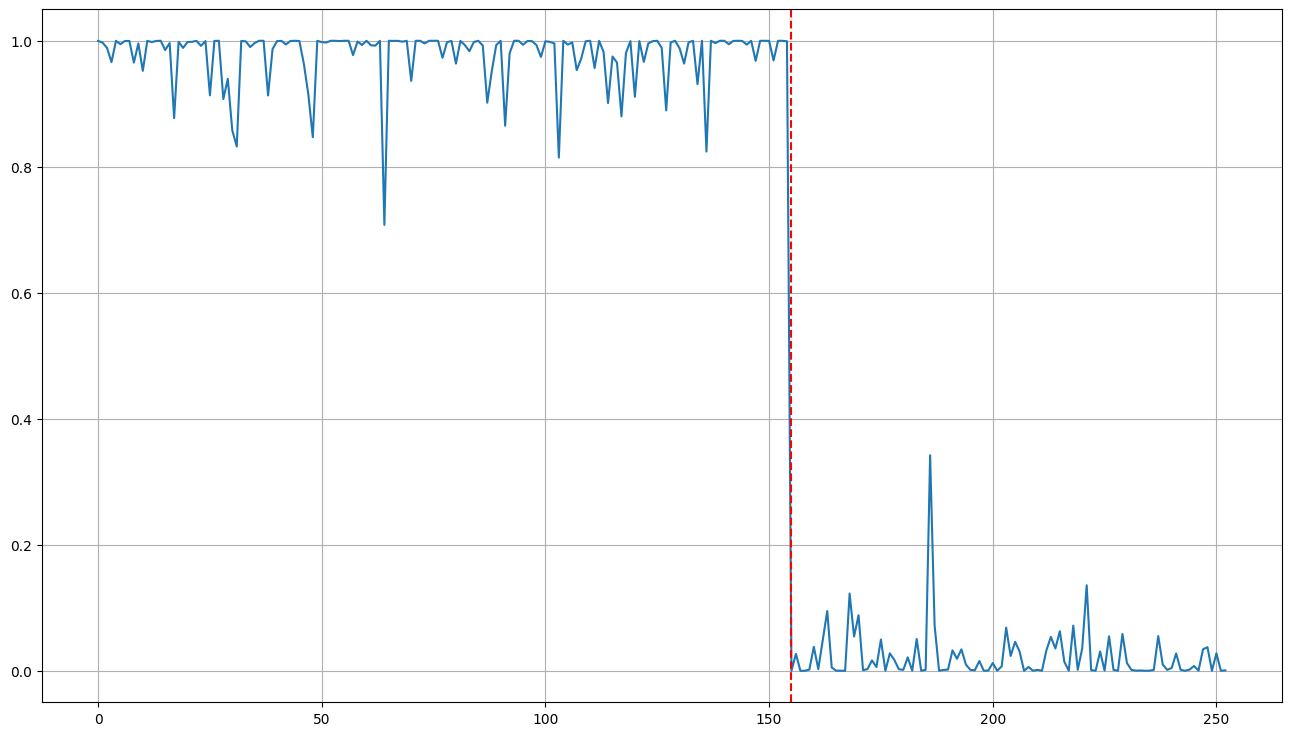

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [ ]:
model

BrainTumorCNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
no_of_layers = 0
conv_layers = []

In [ ]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [ ]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [ ]:
conv_layers


[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

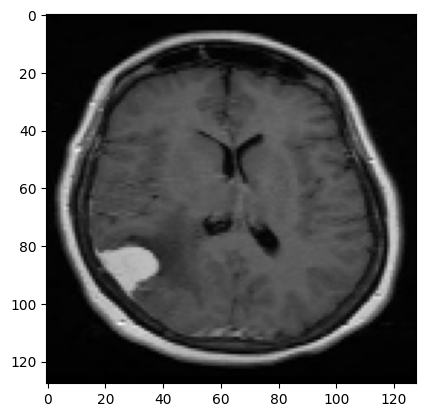

In [ ]:
img = dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [ ]:
img = torch.from_numpy(img).to(device)


In [ ]:
img.shape

torch.Size([3, 128, 128])

In [ ]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [ ]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


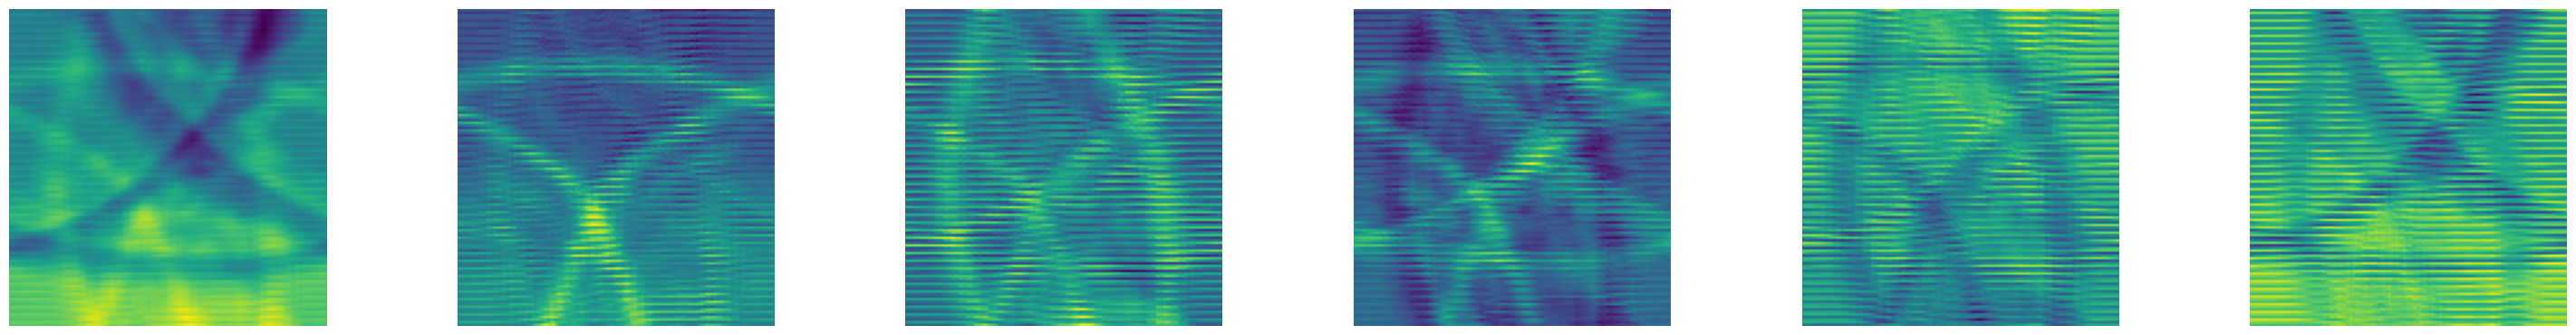

Layer  2


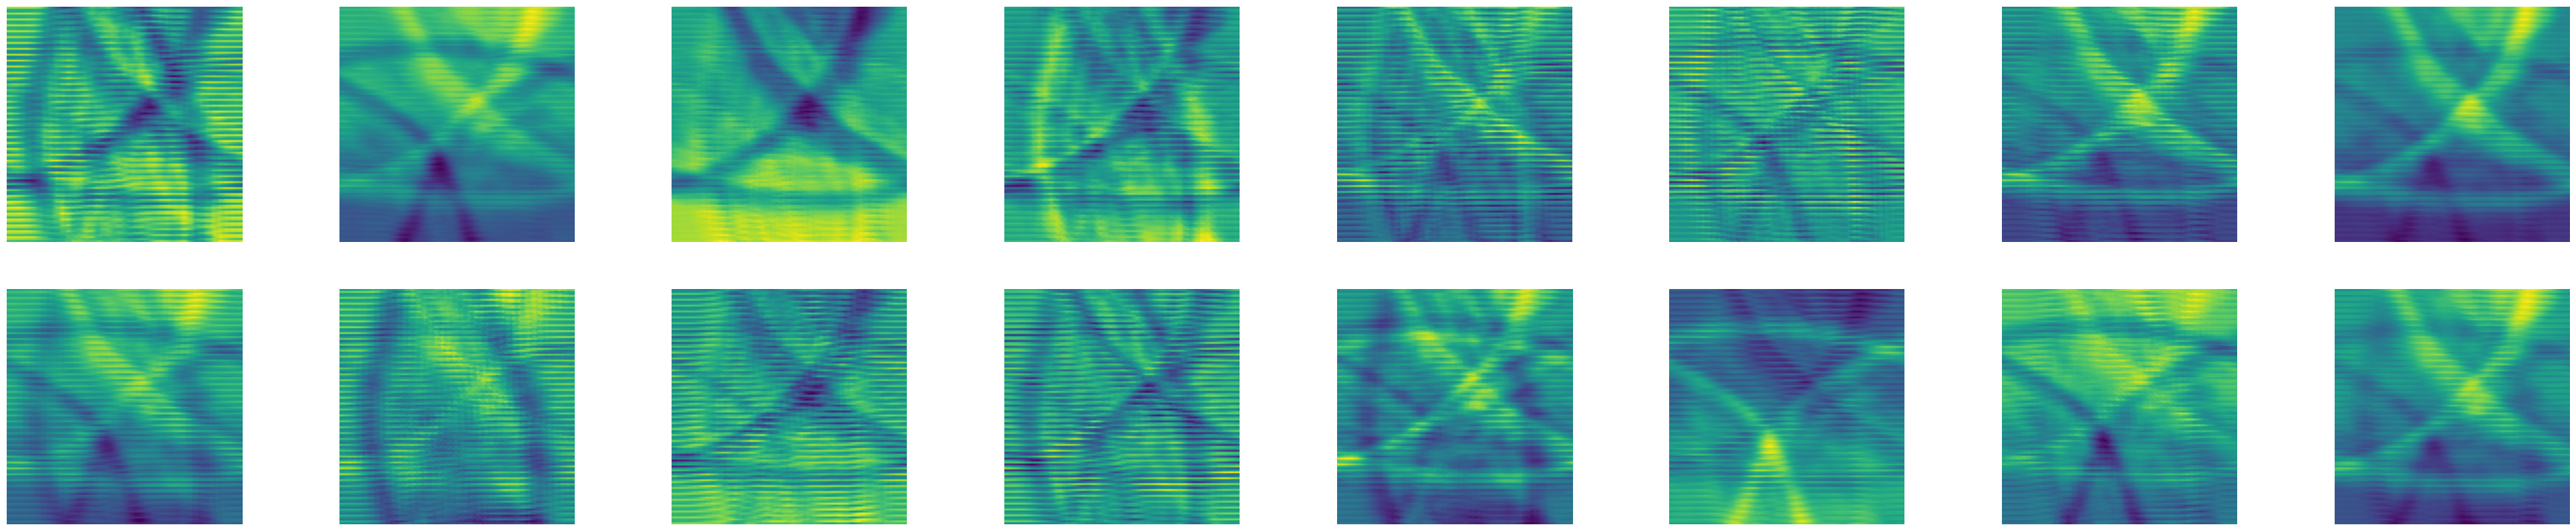

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

#Check Overfitting

In [25]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

class MRI(Dataset):

    def __init__(self):

        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'

        healthy = []
        tumor = []

        self.readAndReshapeImages(tumor, "./archive/archive/yes")
        self.readAndReshapeImages(healthy, "./archive/archive/no")

        #our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

         #our labels
        t_Labels =  np.ones(tumor.shape[0], dtype=np.float32)
        non_t_Labels = np.zeros(healthy.shape[0], dtype=np.float32)

        #All Images
        self.images = np.concatenate((tumor, healthy), axis=0)
        #All Labels
        self.labels = np.concatenate((t_Labels,non_t_Labels), axis=0)


    def readAndReshapeImages(self,array, path):
        for imageName in glob.iglob(f"./{path}/*.jpg"):
            img = cv2.imread(imageName)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
            array.append(img)


    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}

        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

#newTesting

In [27]:
import os
import glob
import cv2
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MRI(Dataset):

    def __init__(self, root_dir="./archive/archive"):
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'

        healthy = []
        tumor = []

        self.readAndReshapeImages(tumor, os.path.join(root_dir, "yes"))
        self.readAndReshapeImages(healthy, os.path.join(root_dir, "no"))

        # Convert images to numpy arrays
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        # Create labels
        t_Labels = np.ones(tumor.shape[0], dtype=np.float32)
        non_t_Labels = np.zeros(healthy.shape[0], dtype=np.float32)

        # Combine all images and labels
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((t_Labels, non_t_Labels), axis=0)

        # Normalize the images
        self.normalize()

        # Split the data into training and validation sets
        self.train_val_split()

        # Save the training and validation images into separate folders
        self.save_images_to_folders()

    def readAndReshapeImages(self, array, path):
        for imageName in glob.iglob(f"{path}/*.jpg"):
            img = cv2.imread(imageName)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.transpose((2, 0, 1))  # Rearrange dimensions to CxHxW
            array.append(img)

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
            train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        elif self.mode == 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0

    def save_images_to_folders(self):
        # Create directories for train and test images
        train_dir = "trainImages"
        test_dir = "testImages"

        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        # Save training images
        for idx, image in enumerate(self.X_train):
            label = int(self.y_train[idx])
            label_dir = os.path.join(train_dir, "tumor" if label == 1 else "healthy")
            os.makedirs(label_dir, exist_ok=True)
            image_path = os.path.join(label_dir, f"train_{idx}.jpg")
            cv2.imwrite(image_path, image.transpose(1, 2, 0) * 255)

        # Save validation images
        for idx, image in enumerate(self.X_val):
            label = int(self.y_val[idx])
            label_dir = os.path.join(test_dir, "tumor" if label == 1 else "healthy")
            os.makedirs(label_dir, exist_ok=True)
            image_path = os.path.join(label_dir, f"val_{idx}.jpg")
            cv2.imwrite(image_path, image.transpose(1, 2, 0) * 255)

# Example usage
mri_dataset = MRI()
mri_dataset.save_images_to_folders()


In [28]:
import os
import glob
import cv2
import numpy as np

def load_images_from_folder(folder):
    images = []
    labels = []

    tumor_folder = os.path.join(folder, 'tumor')
    healthy_folder = os.path.join(folder, 'healthy')

    # Load tumor images
    for filename in glob.glob(os.path.join(tumor_folder, '*.jpg')):
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = img / 255.0  # Normalize the image
            images.append(img)
            labels.append(1)  # Tumor label

    # Load healthy images
    for filename in glob.glob(os.path.join(healthy_folder, '*.jpg')):
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = img / 255.0  # Normalize the image
            images.append(img)
            labels.append(0)  # Healthy label

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)

# Paths to train and test folders
train_folder = './trainImages'
test_folder = './testImages'

# Load images
train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)

# Output the shapes of the datasets
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')


Train images shape: (202, 128, 128, 3)
Train labels shape: (202,)
Test images shape: (51, 128, 128, 3)
Test labels shape: (51,)


In [29]:
!zip -r trainImages.zip trainImages
!zip -r testImages.zip testImages
from google.colab import files

# Download the zipped trainImages folder
files.download('trainImages.zip')

# Download the zipped testImages folder
files.download('testImages.zip')



  adding: trainImages/ (stored 0%)
  adding: trainImages/healthy/ (stored 0%)
  adding: trainImages/healthy/train_78.jpg (deflated 4%)
  adding: trainImages/healthy/train_149.jpg (deflated 2%)
  adding: trainImages/healthy/train_132.jpg (deflated 3%)
  adding: trainImages/healthy/train_171.jpg (deflated 6%)
  adding: trainImages/healthy/train_178.jpg (deflated 3%)
  adding: trainImages/healthy/train_164.jpg (deflated 6%)
  adding: trainImages/healthy/train_88.jpg (deflated 3%)
  adding: trainImages/healthy/train_77.jpg (deflated 5%)
  adding: trainImages/healthy/train_147.jpg (deflated 2%)
  adding: trainImages/healthy/train_129.jpg (deflated 3%)
  adding: trainImages/healthy/train_158.jpg (deflated 2%)
  adding: trainImages/healthy/train_98.jpg (deflated 3%)
  adding: trainImages/healthy/train_116.jpg (deflated 3%)
  adding: trainImages/healthy/train_188.jpg (deflated 3%)
  adding: trainImages/healthy/train_162.jpg (deflated 3%)
  adding: trainImages/healthy/train_127.jpg (deflated 9%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Are we Overfitting

In [30]:
dataset = BrainTumor()
dataset.normalize()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = BrainTumorCNN().to(device)

cpu


In [31]:
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [32]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [33]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [34]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # validate for the current epoch
    val_losses = []
    model.eval()

    dataset.mode = 'val'

    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))


Train Epoch: 10	Train Loss: 0.622154	Val Loss: 0.625494
Train Epoch: 20	Train Loss: 0.593639	Val Loss: 0.594900
Train Epoch: 30	Train Loss: 0.548756	Val Loss: 0.550496
Train Epoch: 40	Train Loss: 0.530267	Val Loss: 0.534376
Train Epoch: 50	Train Loss: 0.519937	Val Loss: 0.523024
Train Epoch: 60	Train Loss: 0.506707	Val Loss: 0.511399
Train Epoch: 70	Train Loss: 0.495913	Val Loss: 0.496837
Train Epoch: 80	Train Loss: 0.486943	Val Loss: 0.481266
Train Epoch: 90	Train Loss: 0.460116	Val Loss: 0.462196
Train Epoch: 100	Train Loss: 0.442737	Val Loss: 0.444743
Train Epoch: 110	Train Loss: 0.441392	Val Loss: 0.425455
Train Epoch: 120	Train Loss: 0.413807	Val Loss: 0.410528
Train Epoch: 130	Train Loss: 0.396624	Val Loss: 0.395794
Train Epoch: 140	Train Loss: 0.378943	Val Loss: 0.380734
Train Epoch: 150	Train Loss: 0.364106	Val Loss: 0.370826
Train Epoch: 160	Train Loss: 0.349543	Val Loss: 0.353437
Train Epoch: 170	Train Loss: 0.335713	Val Loss: 0.336846
Train Epoch: 180	Train Loss: 0.319577	Va

Text(0, 0.5, 'Loss')

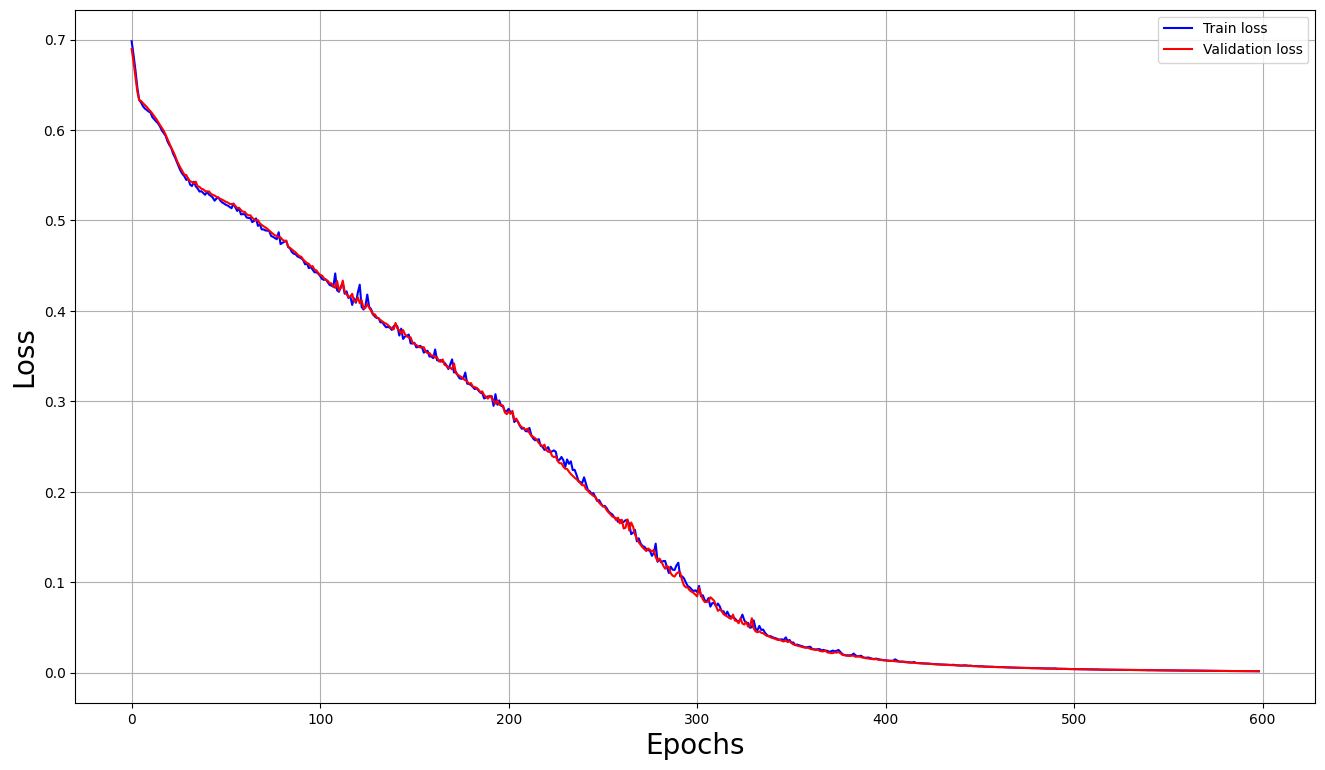

In [35]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

In [36]:
torch.save(model.state_dict(), 'model.pth')

In [37]:
print(os.listdir("./archive/archive/yes"))

['nt_11.jpg', 'nt_114.jpg', 'nt_126.jpg', 'nt_26.jpg', 'nt_147.jpg', 'nt_81.jpg', 'nt_2.jpg', 'nt_90.jpg', 'nt_73.jpg', 'nt_124.jpg', 'nt_77.jpg', 'nt_69.jpg', 'nt_34.jpg', 'nt_30.jpg', 'nt_95.jpg', 'nt_109.jpg', 'nt_7.jpg', 'nt_145.jpg', 'nt_140.jpg', 'nt_63.jpg', 'nt_55.jpg', 'nt_24.jpg', 'nt_32.jpg', 'nt_97.jpg', 'nt_135.jpg', 'nt_52.jpg', 'nt_8.jpg', 'nt_152.jpg', 'nt_104.jpg', 'nt_48.jpg', 'nt_12.jpg', 'nt_127.jpg', 'nt_149.jpg', 'nt_46.jpg', 'nt_28.jpg', 'nt_71.jpg', 'nt_33.jpg', 'nt_25.jpg', 'nt_41.jpg', 'nt_68.jpg', 'nt_155.jpg', 'nt_61.jpg', 'nt_125.jpg', 'nt_57.jpg', 'nt_42.jpg', 'nt_76.jpg', 'nt_92.jpg', 'nt_150.jpg', 'nt_45.jpg', 'nt_111.jpg', 'nt_10.jpg', 'nt_40.jpg', 'nt_4.jpg', 'nt_31.jpg', 'nt_58.jpg', 'nt_72.jpg', 'nt_5.jpg', 'nt_146.jpg', 'nt_108.jpg', 'nt_53.jpg', 'nt_113.jpg', 'nt_96.jpg', 'nt_84.jpg', 'nt_21.jpg', 'nt_27.jpg', 'nt_75.jpg', 'nt_143.jpg', 'nt_74.jpg', 'nt_91.jpg', 'nt_36.jpg', 'nt_50.jpg', 'nt_51.jpg', 'nt_148.jpg', 'nt_9.jpg', 'nt_141.jpg', 'nt_65.j

#Function for the Web to check the Tumor

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define the function to predict tumor presence
def predict_tumor(image_path, model_path):
    # Load the saved model
    model = BrainTumorCNN()  # Assuming BrainTumorCNN is defined as in your previous code
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode

    # Define image transformations
    image_transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize the image to 128x128
        transforms.ToTensor(),           # Convert PIL image to tensor
        transforms.Normalize((0, 0, 0), (1/255, 1/255, 1/255))  # Normalize the image by dividing by 255
    ])

    # Load and preprocess the image
    image = Image.open(image_path)
    image = image_transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Perform prediction
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.round(output).item()  # Round the output to get binary prediction (0 or 1)

    # Interpret the prediction
    if predicted_class == 0:
        return "Healthy (No tumor detected)"
    else:
        return "Tumorous (Tumor detected)"


# Example usage:
image_path = "./archive/archive/yes/nt_118.jpg"
model_path = "model.pth"
result = predict_tumor(image_path, model_path)
print(result)


Tumorous (Tumor detected)


In [ ]:
print(os.listdir("./archive/archive/yes"))

['nt_154.jpg', 'nt_104.jpg', 'nt_4.jpg', 'nt_36.jpg', 'nt_50.jpg', 'nt_100.jpg', 'nt_29.jpg', 'nt_33.jpg', 'nt_32.jpg', 'nt_9.jpg', 'nt_98.jpg', 'nt_59.jpg', 'nt_143.jpg', 'nt_125.jpg', 'nt_82.jpg', 'nt_76.jpg', 'nt_27.jpg', 'nt_92.jpg', 'nt_47.jpg', 'nt_103.jpg', 'nt_15.jpg', 'nt_129.jpg', 'nt_99.jpg', 'nt_49.jpg', 'nt_123.jpg', 'nt_89.jpg', 'nt_71.jpg', 'nt_135.jpg', 'nt_149.jpg', 'nt_37.jpg', 'nt_139.jpg', 'nt_141.jpg', 'nt_48.jpg', 'nt_93.jpg', 'nt_28.jpg', 'nt_26.jpg', 'nt_1.jpg', 'nt_142.jpg', 'nt_114.jpg', 'nt_7.jpg', 'nt_83.jpg', 'nt_51.jpg', 'nt_56.jpg', 'nt_81.jpg', 'nt_102.jpg', 'nt_72.jpg', 'nt_16.jpg', 'nt_77.jpg', 'nt_60.jpg', 'nt_53.jpg', 'nt_46.jpg', 'nt_87.jpg', 'nt_153.jpg', 'nt_146.jpg', 'nt_11.jpg', 'nt_127.jpg', 'nt_155.jpg', 'nt_52.jpg', 'nt_73.jpg', 'nt_22.jpg', 'nt_120.jpg', 'nt_136.jpg', 'nt_134.jpg', 'nt_152.jpg', 'nt_67.jpg', 'nt_111.jpg', 'nt_96.jpg', 'nt_40.jpg', 'nt_118.jpg', 'nt_66.jpg', 'nt_5.jpg', 'nt_55.jpg', 'nt_54.jpg', 'nt_115.jpg', 'nt_30.jpg', 'nt